# Train/test classifier

In [29]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

# Hide deprecated warnings
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [30]:
#fv = pd.read_csv('feature_vector.csv')

In [31]:
#import vector_data 
fv=pd.read_csv("/Users/AirMorena/Desktop/final_proj/csv/google_play_store/170619final_feature_vector.csv")

In [32]:
fv.shape

(9351, 73)

In [33]:
fv.columns

Index(['Successful_App', 'Type_Free', 'Type_Paid', 'Size_group_big',
       'Size_group_small', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'Current Ver_clean_levels_high',
       'Current Ver_clean_levels_low', 'Current Ver_clean_levels_medium',
       'reviews_levels_high', 'reviews_levels_low', 'reviews_levels_medium',
       'Android Ver_levels_high', 'Android Ver_levels_low',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Mature 17+',
       'Content Rating_Teen', 'Content Rating_Unrated',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Categ

## Train/Test Split

In [34]:
X = fv.drop(['Successful_App'], axis=1)
y = fv['Successful_App']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression - Grid Search & Cross Validation

See the list of scoring functions [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [35]:
# Initialize the model
logistic = LogisticRegression()

# Define the values of the hyperparameters to optimize
penalty = ['l1']
C=[0.1, 0.2, 0.4, 0.6, 0.8, 1] # C = 1/λ
solver=['liblinear', 'saga']
hyperparameters = dict(penalty=penalty, C=C, solver=solver)

# Initialize GridSearch/Cross-validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, scoring='accuracy')

# Run the optimization
best_model = clf.fit(X_train, y_train)

In [36]:
# Results
best_model.cv_results_

{'mean_fit_time': array([0.04731784, 0.20651307, 0.0560163 , 0.21142964, 0.09328318,
        0.2149426 , 0.10940747, 0.20486035, 0.13326654, 0.30245399,
        0.13561702, 0.33522358]),
 'std_fit_time': array([0.01210862, 0.01427815, 0.00826093, 0.01455841, 0.01398082,
        0.00989204, 0.02361466, 0.0104698 , 0.02392486, 0.02036294,
        0.01653454, 0.04509307]),
 'mean_score_time': array([0.00227175, 0.00220938, 0.00217042, 0.00167527, 0.00184307,
        0.00184574, 0.00172033, 0.00172229, 0.00243397, 0.00220146,
        0.00194564, 0.00238719]),
 'std_score_time': array([0.00093646, 0.00031689, 0.00107401, 0.00014782, 0.00031851,
        0.00029463, 0.00034294, 0.00017922, 0.00093847, 0.00044454,
        0.00036712, 0.00083316]),
 'param_C': masked_array(data=[0.1, 0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             

In [37]:
# Set of hyperparameters from the model that perform the best on average from all cross validations
best_model.best_params_

{'C': 0.4, 'penalty': 'l1', 'solver': 'liblinear'}

In [38]:
# Average value for the metric for the model evaluation in the best set of hyperparameters
best_model.best_score_

0.8406417112299466

### Extract factors that are relevant after regularization and store them for analysis

In [39]:
# Save best regularized coefficients for logistic regression analysis
logistic = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
logistic.fit(X_train, y_train)
coefficients = pd.DataFrame({'features': X_train.columns, 'coefficients': logistic.coef_[0]})
coefficients.to_csv("logistic_regularization_coefficients.csv", index=False, encoding='utf-8')

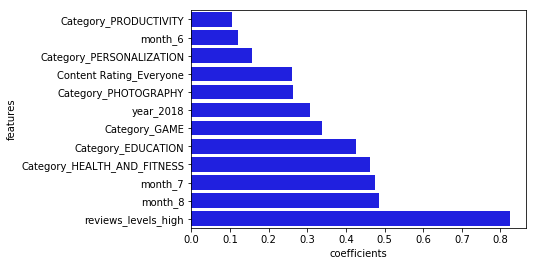

In [40]:
relevance_factors = coefficients[coefficients['coefficients']>0].sort_values(by='coefficients')
_=sns.barplot(x='coefficients', y='features', data=relevance_factors, color='blue')

#### Visualize the results of hyperparameter optimization grid search

In [41]:
params = best_model.cv_results_['params']
train_scores = best_model.cv_results_['mean_train_score']
test_scores = best_model.cv_results_['mean_test_score']
times = best_model.cv_results_['mean_fit_time']

GS_performance = pd.DataFrame({'C': [i['C'] for i in params],
                                 'solver': [i['solver'] for i in params],
                                 'train_score': train_scores,
                                 'test_score': test_scores,
                                 'fit_time': times})

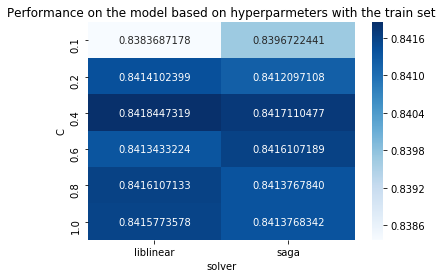

In [42]:
_=sns.heatmap(GS_performance[['C','solver','train_score']].pivot_table(values='train_score', index='C', 
                          columns='solver'), annot=True, fmt='.10f', cmap='Blues')
_=plt.title("Performance on the model based on hyperparmeters with the train set")

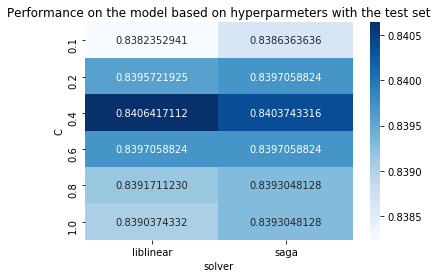

In [43]:
_=sns.heatmap(GS_performance[['C','solver','test_score']].pivot_table(values='test_score', index='C', 
                          columns='solver'), annot=True, fmt='.10f', cmap='Blues')
_=plt.title("Performance on the model based on hyperparmeters with the test set")

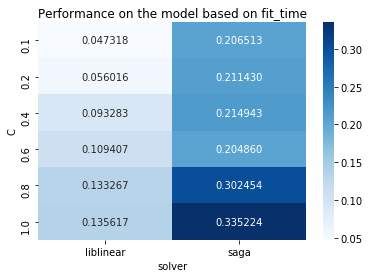

In [44]:
_=sns.heatmap(GS_performance[['C','solver','fit_time']].pivot_table(values='fit_time', index='C', columns='solver'),
             annot=True, fmt='.6f', cmap='Blues')
_=plt.title("Performance on the model based on fit_time")

## Logistic Regression trained - Final value of the cross entropy (loss function)

**It requires the predicted probability of the class being class 1!!**

```-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))```

In [45]:
# Use only the training set to calculate it
y_pred_train = best_model.predict_proba(X_train)
y_pred_test = best_model.predict_proba(X_test)

# Calculate cross entropy of true vs predict
cross_entropy_train = log_loss(y_train, y_pred_train)
cross_entropy_test = log_loss(y_test, y_pred_test)

In [46]:
print("The logistic regression was optimized until reaching a loss of {:.2f} with the trainig set.\nThe model has a cross entropy value of {:.2f} when using test data.".format(cross_entropy_train, cross_entropy_test))

The logistic regression was optimized until reaching a loss of 0.33 with the trainig set.
The model has a cross entropy value of 0.35 when using test data.


In [47]:
# Predict if the interviewed people in the test set are taking treatment of not
y_pred = best_model.predict(X_test)

## Logistic Regression - Best Model Evaluation

![precision_recall](prec_recall.png "Title")

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1347
           1       0.71      0.71      0.71       524

   micro avg       0.84      0.84      0.84      1871
   macro avg       0.80      0.80      0.80      1871
weighted avg       0.84      0.84      0.84      1871



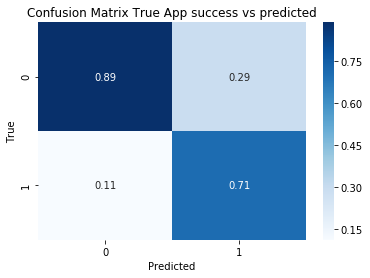

In [49]:
# Normalized (by the number of interviewed people in each class) confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=0)

_=sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
_=plt.xlabel('Predicted')
_=plt.ylabel('True')
_=plt.title("Confusion Matrix True App success vs predicted")

### What is the best probability threshold to decide if, based on the given situation, the person is taking mental treatment?

In [50]:
best_model.predict(X_test)

array([0, 0, 0, ..., 1, 1, 0])

In [51]:
# Predict the probabilities of being taking treatment
y_pred_test = best_model.predict_proba(X_test)

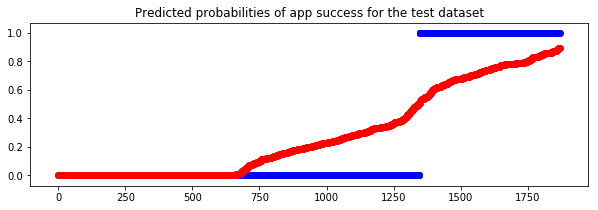

In [52]:
_=plt.figure(figsize=(10,3))
_=plt.scatter(range(0, len(y_pred_test[:,1])), np.sort(y_test.as_matrix()), color='b')
_=plt.scatter(range(0, len(y_pred_test[:,1])), np.sort(y_pred_test[:,1]), color='r')
_=plt.title("Predicted probabilities of app success for the test dataset")

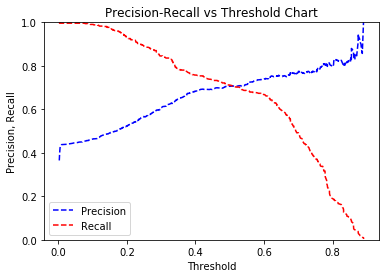

In [53]:
# Visualize how the precision and the recall changes when moving the threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test[:, 1]) 
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
_=plt.ylim([0,1])

### What is the area under the curve according to the optimal threshold?

![ROC_curve](ROC_curves.png "Title")

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test[:, 1])

AUC: 0.899


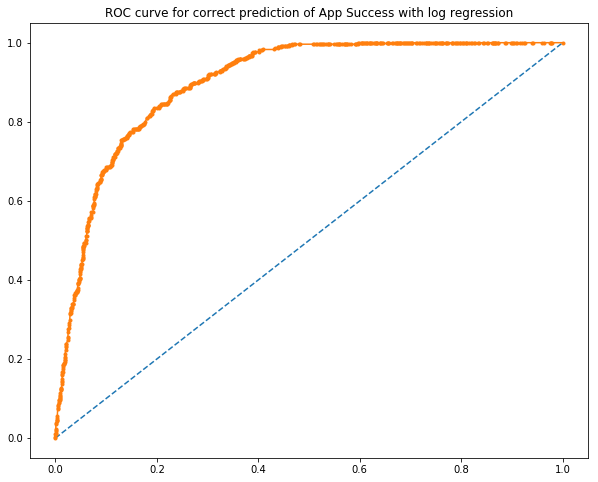

In [57]:
auc = roc_auc_score(y_test, y_pred_test[:, 1])
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test[:, 1])

# plot random case
_=plt.figure(figsize=(10, 8))
_=plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
_=plt.plot(fpr, tpr, marker='.')
_=plt.title("ROC curve for correct prediction of App Success with log regression")

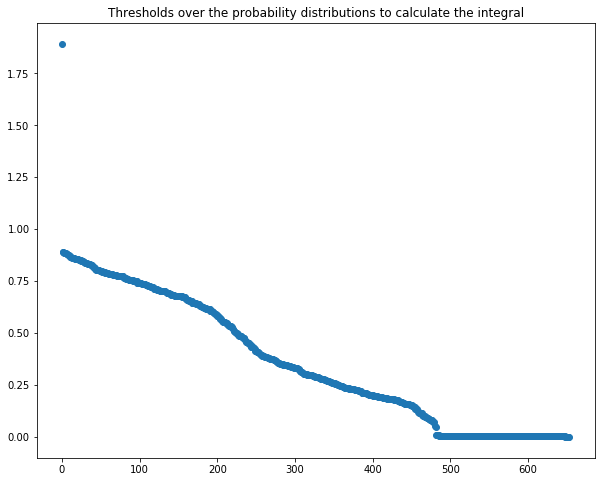

In [56]:
_=plt.figure(figsize=(10, 8))
_=plt.scatter(range(0, len(thresholds)), thresholds)
_=plt.title('Thresholds over the probability distributions to calculate the integral')